In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# Define paths
base_dir = '/content/drive/MyDrive/Machine_Learning_Final_Project/Splitted_Data'  # Change this to a directory within your Google Drive
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validate')
test_dir = os.path.join(base_dir, 'test')

# List of classes
classes = ['Healthy', 'Brain_Tumor']

# Function to count images
def count_images(directory, classes):
    counts = {}
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if os.path.exists(class_dir):
            counts[class_name] = len(os.listdir(class_dir))
        else:
            counts[class_name] = 0
    return counts

# Count the number of images in the training, validation, and unseen sets
train_counts = count_images(train_dir, classes)
validation_counts = count_images(validation_dir, classes)
test_counts = count_images(test_dir, classes)

print("Training set counts:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} images")

print("\nValidation set counts:")
for class_name, count in validation_counts.items():
    print(f"{class_name}: {count} images")

print("\nUnseen set counts:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count} images")

Training set counts:
Healthy: 1669 images
Brain_Tumor: 2010 images

Validation set counts:
Healthy: 208 images
Brain_Tumor: 251 images

Unseen set counts:
Healthy: 210 images
Brain_Tumor: 252 images


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
num_classes = train_generator.num_classes  # Ensure this matches the number of classes in your dataset
predictions = Dense(num_classes, activation='softmax')(x)

# Combine base model with custom layers
model_resnet50_25 = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_resnet50_25.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_resnet50_25 = model_resnet50_25.fit(
    train_generator,
    epochs=25,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

# Final evaluation on validation data
final_val_loss, final_val_accuracy = model_resnet50_25.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Final validation accuracy: {final_val_accuracy:.4f}")
print(f"Final validation loss: {final_val_loss:.4f}")


Found 3679 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Found 462 images belonging to 2 classes.
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/25
115/115 [==============================] - 585s 5s/step - loss: 0.6832 - accuracy: 0.5814 - val_loss: 0.5755 - val_accuracy: 0.7429
Epoch 2/25
115/115 [==============================] - 386s 3s/step - loss: 0.6688 - accuracy: 0.6051 - val_loss: 0.5701 - val_accuracy: 0.7342
Epoch 3/25
115/115 [==============================] - 383s 3s/step - loss: 0.6569 - accuracy: 0.6143 - val_loss: 0.5905 - val_accuracy: 0.7015
Epoch 4/25
115/115 [==============================] - 382s 3s/step - loss: 0.6543 - accuracy: 0.6154 - val_loss: 0.5999 - val_accuracy: 0.6754
Epoch 5/25
115/115 [==============================] - 380s 3s/step - loss: 0.6362 - accuracy: 0.6339 - val_loss: 0.6074 - val_accuracy: 0.6100
Epoch 6/25
115/115 [==============================] - 387s 3s/step - loss: 0.6452 - accuracy: 0.

In [ ]:
# Predict on test data
test_generator.reset()
preds = model_resnet50_25.predict(test_generator, steps=len(test_generator), verbose=1)
y_true = test_generator.classes
y_pred = np.argmax(preds, axis=1)

# Print classification report and confusion matrix
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))

15/15 [==============================] - 104s 7s/step
Classification Report
              precision    recall  f1-score   support

 Brain_Tumor       0.75      0.77      0.76       252
     Healthy       0.72      0.69      0.70       210

    accuracy                           0.73       462
   macro avg       0.73      0.73      0.73       462
weighted avg       0.73      0.73      0.73       462

Confusion Matrix
[[195  57]
 [ 66 144]]


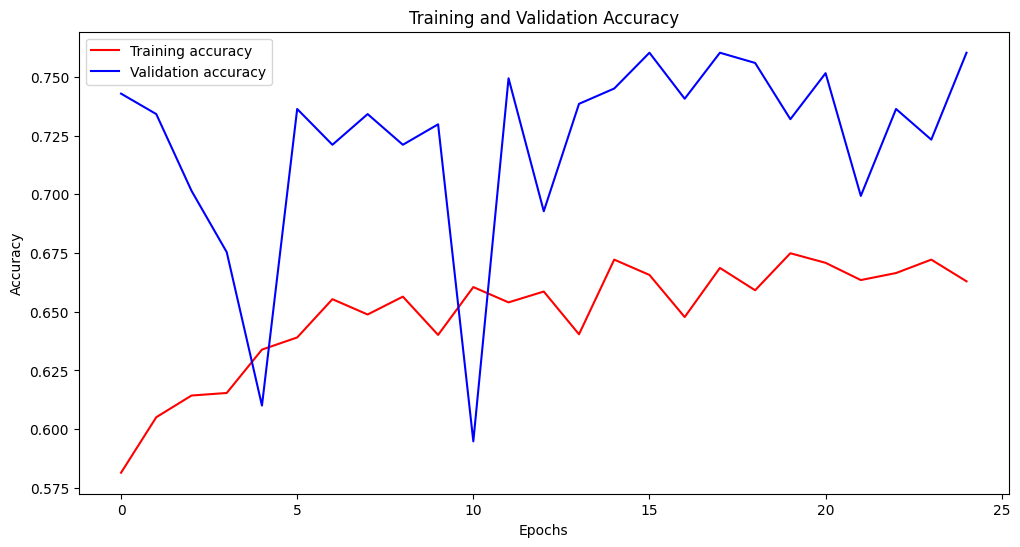

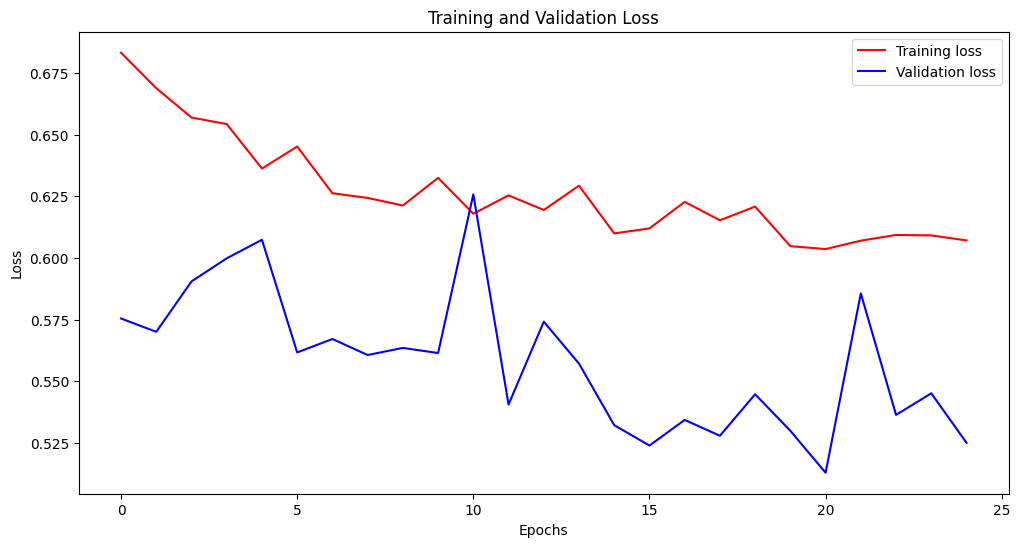

14/14 [==============================] - 40s 3s/step - loss: 0.5266 - accuracy: 0.7567
Final validation accuracy: 0.7567
Final validation loss: 0.5266


In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model
acc = hist_resnet50_25.history['accuracy']
val_acc = hist_resnet50_25.history['val_accuracy']
loss = hist_resnet50_25.history['loss']
val_loss = hist_resnet50_25.history['val_loss']

epochs = range(len(acc))

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Final evaluation on validation data
final_loss, final_accuracy = model_resnet50_25.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Final validation accuracy: {final_accuracy:.4f}")
print(f"Final validation loss: {final_loss:.4f}")


In [ ]:
# Evaluation on test data (unseen data)
final_test_loss, final_test_accuracy = model_resnet50_25.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Final test accuracy: {final_test_accuracy:.4f}")
print(f"Final test loss: {final_test_loss:.4f}")

14/14 [==============================] - 39s 3s/step - loss: 0.5490 - accuracy: 0.7299
Final test accuracy: 0.7299
Final test loss: 0.5490


15/15 [==============================] - 39s 3s/step
Classification Report
              precision    recall  f1-score   support

 Brain_Tumor       0.75      0.77      0.76       252
     Healthy       0.72      0.69      0.70       210

    accuracy                           0.73       462
   macro avg       0.73      0.73      0.73       462
weighted avg       0.73      0.73      0.73       462

Confusion Matrix
[[195  57]
 [ 66 144]]


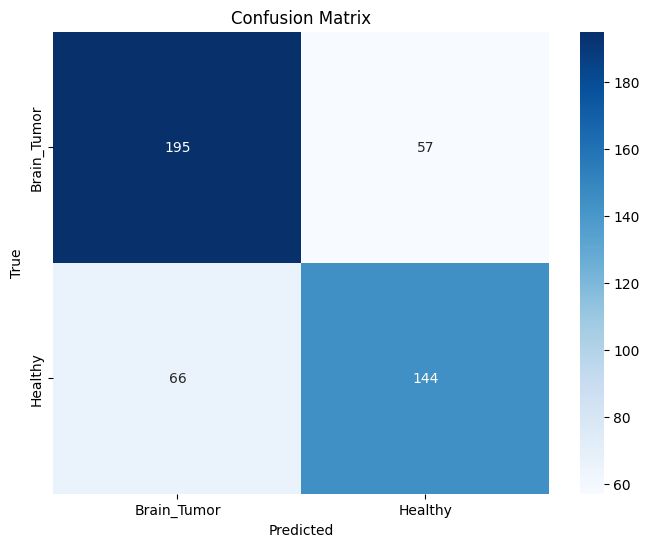

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Predict on test data
test_generator.reset()
Y_pred = model_resnet50_25.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

# Classification report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion matrix
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
num_classes = train_generator.num_classes  # Ensure this matches the number of classes in your dataset
predictions = Dense(num_classes, activation='softmax')(x)

# Combine base model with custom layers
model_resnet50_50 = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_resnet50_50.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_resnet50_50 = model_resnet50_50.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

# Final evaluation on validation data
final_val_loss, final_val_accuracy = model_resnet50_50.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Final validation accuracy: {final_val_accuracy:.4f}")
print(f"Final validation loss: {final_val_loss:.4f}")


Found 3679 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Found 462 images belonging to 2 classes.
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/50
115/115 [==============================] - 852s 7s/step - loss: 0.6950 - accuracy: 0.5700 - val_loss: 0.6010 - val_accuracy: 0.7211
Epoch 2/50
115/115 [==============================] - 378s 3s/step - loss: 0.6726 - accuracy: 0.5958 - val_loss: 0.5739 - val_accuracy: 0.7495
Epoch 3/50
115/115 [==============================] - 371s 3s/step - loss: 0.6508 - accuracy: 0.6192 - val_loss: 0.5681 - val_accuracy: 0.7582
Epoch 4/50
115/115 [==============================] - 373s 3s/step - loss: 0.6376 - accuracy: 0.6420 - val_loss: 0.6100 - val_accuracy: 0.6841
Epoch 5/50
115/115 [==============================] - 371s 3s/step - loss: 0.6414 - accuracy: 0.6344 - val_loss: 0.6066 - val_accuracy: 0.6667
Epoch 6/50
115/115 [==============================] - 416s 4s/step - loss: 0.6365 - accuracy: 0.

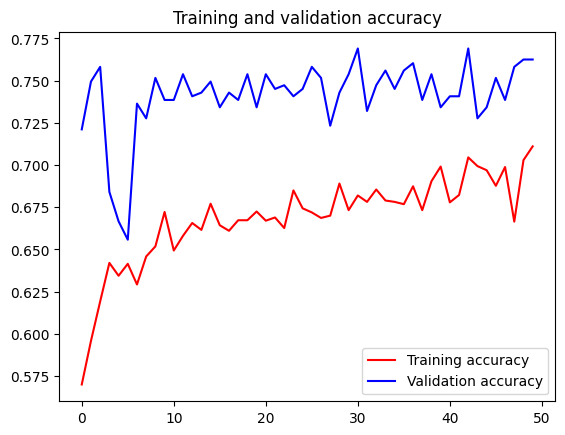

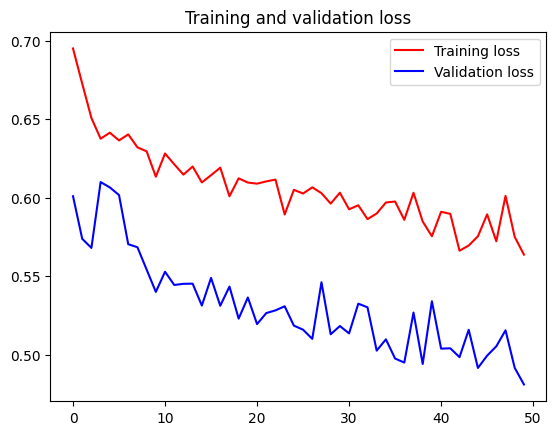

14/14 [==============================] - 46s 3s/step - loss: 0.4757 - accuracy: 0.7701
Final validation accuracy: 0.7701
Final validation loss: 0.4757


In [ ]:
# Evaluate the model
acc = hist_resnet50_50.history['accuracy']
val_acc = hist_resnet50_50.history['val_accuracy']
loss = hist_resnet50_50.history['loss']
val_loss = hist_resnet50_50.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Final evaluation on validation data
final_loss, final_accuracy = model_resnet50_50.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Final validation accuracy: {final_accuracy:.4f}")
print(f"Final validation loss: {final_loss:.4f}")

In [ ]:
# Evaluation on test data (unseen data)
final_test_loss, final_test_accuracy = model_resnet50_50.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Final test accuracy: {final_test_accuracy:.4f}")
print(f"Final test loss: {final_test_loss:.4f}")

14/14 [==============================] - 148s 11s/step - loss: 0.5020 - accuracy: 0.7545
Final test accuracy: 0.7545
Final test loss: 0.5020


15/15 [==============================] - 43s 3s/step
Classification Report
              precision    recall  f1-score   support

 Brain_Tumor       0.74      0.86      0.79       252
     Healthy       0.79      0.64      0.71       210

    accuracy                           0.76       462
   macro avg       0.76      0.75      0.75       462
weighted avg       0.76      0.76      0.75       462

Confusion Matrix
[[216  36]
 [ 76 134]]


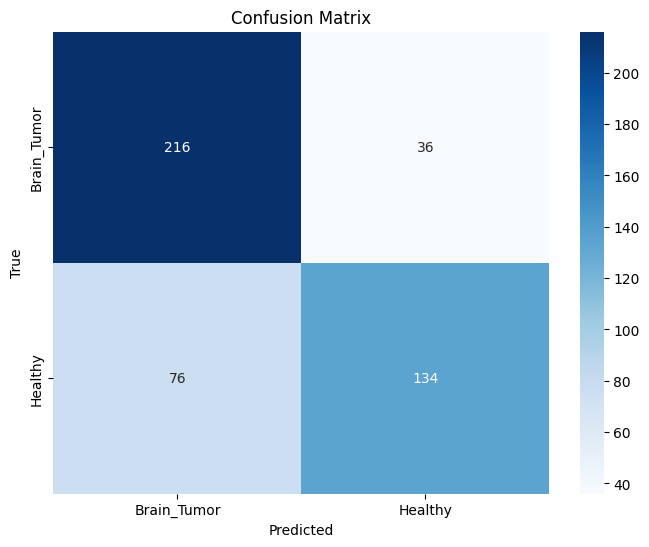

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Predict on test data
test_generator.reset()
Y_pred = model_resnet50_50.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

# Classification report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion matrix
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
num_classes = train_generator.num_classes  # Ensure this matches the number of classes in your dataset
predictions = Dense(num_classes, activation='softmax')(x)

# Combine base model with custom layers
model_resnet50_50_lr = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_resnet50_50_lr.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_resnet50_50_lr = model_resnet50_50_lr.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

# Final evaluation on validation data
final_val_loss, final_val_accuracy = model_resnet50_50_lr.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Final validation accuracy: {final_val_accuracy:.4f}")
print(f"Final validation loss: {final_val_loss:.4f}")


Found 3679 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Found 462 images belonging to 2 classes.
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/50
115/115 [==============================] - 662s 6s/step - loss: 0.6806 - accuracy: 0.5703 - val_loss: 0.6440 - val_accuracy: 0.6688
Epoch 2/50
115/115 [==============================] - 42s 362ms/step - loss: 0.6688 - accuracy: 0.5915 - val_loss: 0.6197 - val_accuracy: 0.6906
Epoch 3/50
115/115 [==============================] - 43s 370ms/step - loss: 0.6527 - accuracy: 0.6287 - val_loss: 0.6060 - val_accuracy: 0.7233
Epoch 4/50
115/115 [==============================] - 43s 374ms/step - loss: 0.6562 - accuracy: 0.6176 - val_loss: 0.5992 - val_accuracy: 0.7407
Epoch 5/50
115/115 [==============================] - 43s 376ms/step - loss: 0.6493 - accuracy: 0.6314 - val_loss: 0.5925 - val_accuracy: 0.7320
Epoch 6/50
115/115 [==============================] - 43s 375ms/step - loss: 0.6455 - ac

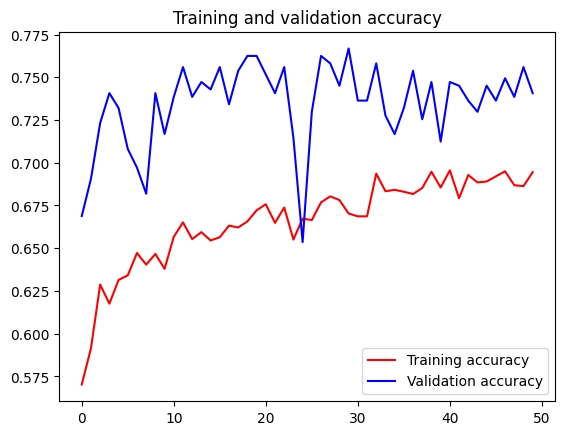

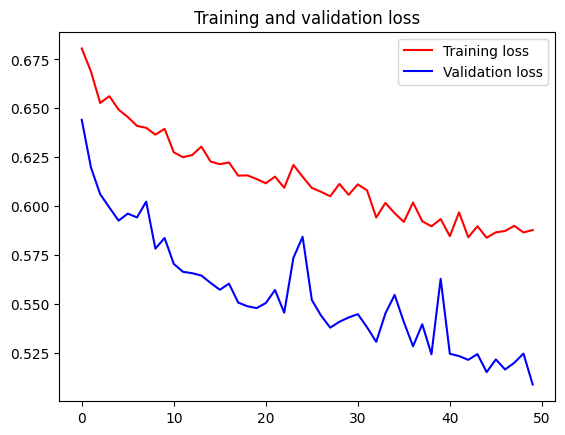

14/14 [==============================] - 2s 146ms/step - loss: 0.5103 - accuracy: 0.7366
Final validation accuracy: 0.7366
Final validation loss: 0.5103


In [5]:
# Evaluate the model
acc = hist_resnet50_50_lr.history['accuracy']
val_acc = hist_resnet50_50_lr.history['val_accuracy']
loss = hist_resnet50_50_lr.history['loss']
val_loss = hist_resnet50_50_lr.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Final evaluation on validation data
final_loss, final_accuracy = model_resnet50_50_lr.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Final validation accuracy: {final_accuracy:.4f}")
print(f"Final validation loss: {final_loss:.4f}")

In [6]:
# Evaluation on test data (unseen data)
final_test_loss, final_test_accuracy = model_resnet50_50_lr.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Final test accuracy: {final_test_accuracy:.4f}")
print(f"Final test loss: {final_test_loss:.4f}")

14/14 [==============================] - 119s 9s/step - loss: 0.5275 - accuracy: 0.7344
Final test accuracy: 0.7344
Final test loss: 0.5275


15/15 [==============================] - 4s 207ms/step
Classification Report
              precision    recall  f1-score   support

 Brain_Tumor       0.71      0.87      0.78       252
     Healthy       0.79      0.58      0.66       210

    accuracy                           0.74       462
   macro avg       0.75      0.72      0.72       462
weighted avg       0.74      0.74      0.73       462

Confusion Matrix
[[219  33]
 [ 89 121]]


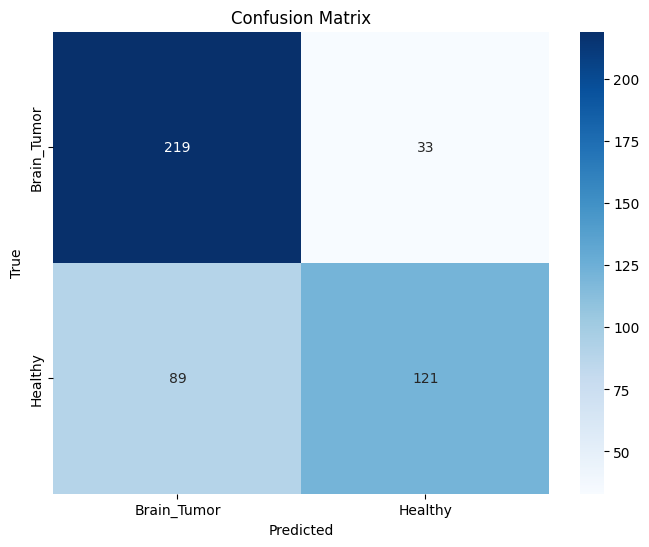

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Predict on test data
test_generator.reset()
Y_pred = model_resnet50_50_lr.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

# Classification report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion matrix
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()